# Коротко про NumPy - vol. I

О чём сегодня поговорим:
- массивы (пройдёмся по типам данных Python и поймём, почему нативные списки - это неэффективно)
- универсальные функции (как сделать работу с массивами ещё эффективнее)

# Часть 1. Массивы

## 1.1. Устройство данных в Python

На первый взгляд может показаться, что незачем разбираться с тем, что у Python под капотом. Действительно: большое количество умных людей придумало классные библиотеки, которыми просто стоит пользоваться, и проблем не будет. Однако в долгой перспективе такой подход крайне не выгоден, потому что не позволяет максимально эффективно использовать имеющиеся в распоряжении специалиста инструменты и мощности. В работе с реальными данными эта неэффективность начнёт проявляться раньше: как только от синтетических примеров вы перейдёте к настоящим рабочим задачам.

Итак, что мы знаем о Python? Прежде всего это язык с динамической типизацией, т.е. в отличие от C или Java, где нужно явно определить тип переменной, в Python это не требуется.

Для сравнения:
```c
// C code
int result = 0;
for(int i=0; i<100; i++) {
  result += i;
}
```
и
```python
# Python code
result = 0
for i in range(100):
  result += i
```

Мы видим, что в случае с Python нам не требовалось явно указывать тип переменной `result` - интерпретатор самостоятельно вывел нужный для работы тип. Это, кстати, позволяет "на лету" записывать в переменную значения разных типов:

In [1]:
x = 123
print(x, type(x), "\n")

x = 0.2
print(x, type(x), "\n")

x = -1j # i ^ 2 = -1
print(x, type(x), "\n")

x = "Hello, Wildberries!"
print(x, type(x), "\n")

123 <class 'int'> 

0.2 <class 'float'> 

(-0-1j) <class 'complex'> 

Hello, Wildberries! <class 'str'> 



И теперь вполне логичный вопрос: а как у Python получается в таком случае реализовывать концепцию динамической типизации? Особенно интересным этот вопрос становится, если принять во внимание что стандартная реализация Python написана как раз-таки на C

Фокус в том, что каждый раз, когда вы пишете когда в роде такого:
```python
x = 17
```
то `x` на самом деле не становится чистым integer'ом. Если говорить формально, то на самом деле это указатель на структуру более сложного вида (например, в версии Python 3.4):
```c
struct _longobject {
 long ob_refcnt;
 PyTypeObject *ob_type;
 size_t ob_size;
 long ob_digit[1];
};
```

Поэтому в итоге "под капотом" это выглядит примерно так:

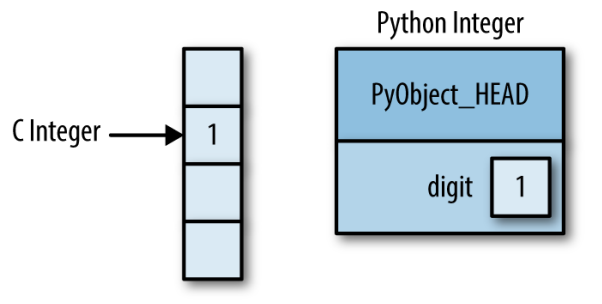

Усложнение структуры хранения с одной стороны делает механизм более гибким, но с другой добавляет накладные расходы на работу

А теперь представим, что вы хотите поработать с каким-то списком в Python. Посмотрим, какие возможности в этом случае есть

In [2]:
L = list(range(10))

L, [type(_) for _ in L]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [int, int, int, int, int, int, int, int, int, int])

Видно, что это список, где каждый из элементов является целым числом. Однако из-за динамической типизации в Python допустим и такой код

In [3]:
L_dynamic = [1, "WB", 0.2, -3j]

L_dynamic, [type(_) for _ in L_dynamic]

([1, 'WB', 0.2, (-0-3j)], [int, str, float, complex])

Как видим, в Python достаточно легко создать список, где каждый объект может быть свого типа. Однако обработка такого списка будет производиться за бóльшее время, в силу накладных расходов, которые есть у каждого элемента.

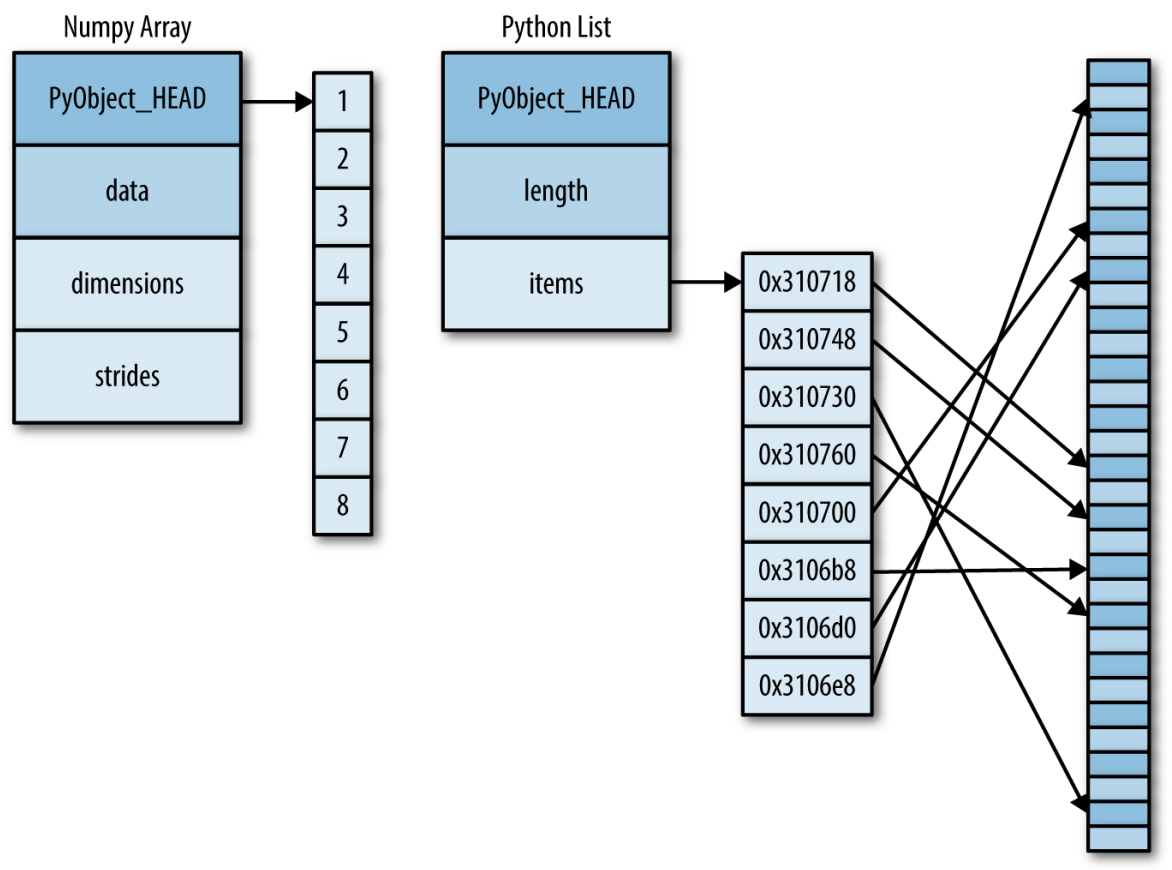

Именно поэтому и возникла потребность в использовании вычислительно более эффективных структур.

В Python есть встроенных механизм работы с однородными данными - библиотека `array`

In [4]:
from array import array

A = array("i", [1, 2, 3, 4, 5]) # i is for Integer
A

array('i', [1, 2, 3, 4, 5])

Если попытаться нарушить однородность, добавив элемент другого типа, то выдастся ошибка

In [8]:
try:
    array("i", [1, 2, 3, 4, "5"])
except Exception as e:
    print("ERROR:\n", e)

ERROR:
 an integer is required (got type str)


Данная библиотека хорошо подходит для хранения массивов, однако в анализе данных этого недостаточно - нужен мощный инструмент для обработки данных, чем и является NumPy

## 1.2. Начало работы в NumPy

In [9]:
import numpy as np
np.__version__

'1.25.2'

Механизм создания списков с помощью NumPy аналогичен тому, что мы видели при использовании библиотеки `array` (за исключением того, что не нужно явно указывать тип - NumPy сделает это самостоятельно и принудительно, если вдруг объекты будут отличаться)

In [10]:
# создание массива из списка однородных элементов
np.array([1, 2, 3])

array([1, 2, 3])

In [11]:
# создание массива из списка элементов различных типов
# (обратите внимание, что приведение типов производится таким образом,
# чтобы в данных не было потерь)
np.array([1, 2.5, 3])

array([1. , 2.5, 3. ])

In [12]:
# приведение типов работает и для на первый взгляд совсем разных объектов
np.array([1, "2", 3])

array(['1', '2', '3'], dtype='<U21')

In [13]:
# если есть желание явно указать целевой тип хранимых данных, то такая опция тоже есть
np.array([1, 2, 3], dtype="float16")

array([1., 2., 3.], dtype=float16)

In [14]:
# вложенные списки становятся многомерными массивами
np.array([[1, 2], [3, 4]])

array([[1, 2],
       [3, 4]])

Возможности создания массивов в NumPy не ограничиваются конвертацией из нативных списков Python. Встроенные возможности позволяют создавать массивы различных типов

In [15]:
# создать массив определённой формы, заполненный нулями
np.zeros(shape=10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
# создать массив определённой формы, заполненный нулями
np.zeros(shape=(2, 3), dtype=int)

array([[0, 0, 0],
       [0, 0, 0]])

In [17]:
# аналогично, но заполнить массив единицами
# обратите внимание, что по дефолту dtype=float
np.ones(shape=(3, 2))

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [19]:
# создание массива, где каждый элемент - заданное значение
np.full(shape=(2, 2), fill_value=np.e)

array([[2.71828183, 2.71828183],
       [2.71828183, 2.71828183]])

In [20]:
# создать массив по аналогии с функцией range
np.arange(0, 10, 3)

array([0, 3, 6, 9])

In [21]:
# создать массив, который заполняет заданным количеством элементов интервал
np.linspace(0, 5, 11)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [22]:
# создать массив из случайных элементов
np.random.random(size=(3, 3))

array([[0.00841699, 0.42619221, 0.7667374 ],
       [0.67748358, 0.6456649 , 0.13822488],
       [0.86169814, 0.92779378, 0.3362311 ]])

Следует отметить, что приведённые выше функции являются лишь небольшим примером функционала, который доступен в NumPy. Есть ещё большое число функций, которые могут быть полезными в разных областях (например, с помощью `np.eye` можно создавать единичную матрицу, которая часто используется в линейной алгебре)

## 1.3. Атрибуты массивов в NumPy

Как и у любого другого объекта в Python, массивы обладают рядом отрибутов, которые могут быть полезны для работы. Опробуем основные из них

In [23]:
# создадим многомерный массив, заполненный случайными целыми числами от 1 до 11 (не включая)
target = np.random.randint(low=1, high=11, size=(2, 3, 4))

target

array([[[ 1,  6,  7,  4],
        [ 1,  7,  7,  7],
        [10,  6, 10, 10]],

       [[ 7,  5,  8,  3],
        [ 4,  2,  4,  2],
        [ 4,  4,  7,  5]]])

In [24]:
print("количество измерений: ", target.ndim)
print("размерности измерений: ", target.shape)
print("общее количество элементов: ", target.size)

количество измерений:  3
размерности измерений:  (2, 3, 4)
общее количество элементов:  24


In [25]:
print("тип элементов массива: ", target.dtype)
print("место в памяти, которое занимает один элемент (в байтах): ", target.itemsize)
print("место в памяти, которое занимает массив целиком (в байтах): ", target.nbytes)

тип элементов массива:  int64
место в памяти, которое занимает один элемент (в байтах):  8
место в памяти, которое занимает массив целиком (в байтах):  192


## 1.4. Индексация массивов

Как и в случае со списками Python при работе с массивами NumPy есть несколько основных способов обращения к элементам объекта. Одним из самых базовых является обращение к одному элементу массива. Посмотрим, как это работает в случае с одномерным массивом

In [29]:
x = np.random.randint(1, 11, 5)
x

array([ 7,  9,  2, 10,  5])

Как и в случае с обычными списками мы можем с помощью `[i]` обращаться к конкретному элементу (не забывайте, что индексация начинается с 0). NumPy аналогично поддерживает и отрицательное индексирование (то есть берёт элементы с конца массива)

In [30]:
print("1й элемент массива: ", x[0])
print("3й элемент массива: ", x[2])
print("Последний элемент массива: ", x[-1])
print("Предпоследний элемент массива: ", x[-2])

1й элемент массива:  7
3й элемент массива:  2
Последний элемент массива:  5
Предпоследний элемент массива:  10


В случае с многомерными массивами подход сохраняется с небольшим усложнением: используется нотация `[i1, i2, ..., in]`. Не забывайте, что можно комбинировать обычное индексирование и отрицательное.

In [31]:
x = np.random.randint(1, 11, (3, 5))
x

array([[2, 7, 8, 2, 8],
       [4, 2, 8, 9, 7],
       [5, 7, 7, 3, 8]])

In [32]:
print("Элемент из первой строки и второго столбца: ", x[0, 1])
print("Элемент из второй строки и четвёртого столбца: ", x[1, 3])
print("Элемент из первой строки и последнего столбца: ", x[0, -1])
print("Элемент из последней строки и последнего столбца: ", x[-1, -1])

Элемент из первой строки и второго столбца:  7
Элемент из второй строки и четвёртого столбца:  9
Элемент из первой строки и последнего столбца:  8
Элемент из последней строки и последнего столбца:  8


## 1.5. Slicing массивов

Slicing массивов NumPy работает по тому же принципу, что и с нативными списками Python (с поправкой на возможность применения на многомерные массивы), т.е. ориентируясь на нотацию `[start:stop:step]`

In [33]:
x = np.random.randint(1, 11, 10)
x

array([ 5, 10,  5,  5,  3,  6,  7,  8,  4,  9])

In [34]:
print("Первые три элемента: ", x[:3])
print("Последние три элемента: ", x[-3:])
print("Все элементы на нечётных позициях: ", x[::2])
print("Все элементы на чётных позициях: ", x[1::2])

Первые три элемента:  [ 5 10  5]
Последние три элемента:  [8 4 9]
Все элементы на нечётных позициях:  [5 5 3 7 4]
Все элементы на чётных позициях:  [10  5  6  8  9]


In [35]:
print("Все элементы в обратном порядке: ", x[::-1])
print("3й и 4й элементы: ", x[2:4])

Все элементы в обратном порядке:  [ 9  4  8  7  6  3  5  5 10  5]
3й и 4й элементы:  [5 5]


И для случая с многомерными массивами

In [36]:
x = np.random.randint(1, 11, (3, 5))
x

array([[10,  6,  5,  5, 10],
       [10,  6,  7,  3,  6],
       [ 3,  3,  3,  4,  8]])

In [37]:
# подмассив, ограниченный первыми двумя строками и тремя столбцами
x[:2, :3]

array([[10,  6,  5],
       [10,  6,  7]])

In [38]:
# подмассив, составленный из нечётных строк и столбцов
x[::2, ::2]

array([[10,  5, 10],
       [ 3,  3,  8]])

In [39]:
# выбор второй строки
x[1, :]

array([10,  6,  7,  3,  6])

In [40]:
# выбор последнего столбца
x[:, -1]

array([10,  6,  8])

Обратите внимание, что работая со слайсами массивов вы продолжаете работать с данными, принадлежащими исходному объекту (слайсинг можно рассматривать как no-copy view). Пример кода ниже проиллюстрирует этот нюанс

In [41]:
x = np.eye(3, dtype=int)
x

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [42]:
# возьмём часть этого массива, 
# расположенную на пересечении первых двух строк и двух последних столбцов
x_part = x[:2, 1:]
x_part

array([[0, 0],
       [1, 0]])

In [43]:
# и заменим в ней элемент, находящийся в первой строке и последнем столбце
x_part[0, 1] = 17
x_part

array([[ 0, 17],
       [ 1,  0]])

In [44]:
# теперь посмотрим на исходный объект
x

array([[ 1,  0, 17],
       [ 0,  1,  0],
       [ 0,  0,  1]])

Как видите, соответствующий элемент искомой многомерного массива также изменился. Чтобы этого избежать нужно явно создавать копию объекта:

In [45]:
x = np.eye(3, dtype=int)
x_part = x[:2, 1:].copy() # <= вот так
x_part[0, 1] = 17

print(x)
print("\n=======\n")
print(x_part)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


[[ 0 17]
 [ 1  0]]


## 1.6. Изменение формы массива

Одной из полезных операций является изменения размеров массива. Основным требованием в этом случае является совместность.

In [46]:
x = np.arange(1, 17)
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
количество измерений:  1
размерности измерений:  (16,)
общее количество элементов:  16


In [47]:
x = x.reshape(4, 4) # обратите внимание, что заполнение массива идёт по порядку измерений
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
количество измерений:  2
размерности измерений:  (4, 4)
общее количество элементов:  16


In [48]:
x = x.reshape(2, 2, 4) # обратите внимание, что заполнение массива идёт по порядку измерений
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[[[ 1  2  3  4]
  [ 5  6  7  8]]

 [[ 9 10 11 12]
  [13 14 15 16]]]
количество измерений:  3
размерности измерений:  (2, 2, 4)
общее количество элементов:  16


In [49]:
x = x.reshape(16, 1) # массив можно превращать в строку/столбец
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[[ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]]
количество измерений:  2
размерности измерений:  (16, 1)
общее количество элементов:  16


In [54]:
x = x.reshape(16) # и возвращать в исходное состояние
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
количество измерений:  1
размерности измерений:  (16,)
общее количество элементов:  16


Удобным также является функционал добавления единичных размерностей

In [55]:
x = x[np.newaxis, :]
print(x) 
print("количество измерений: ", x.ndim)
print("размерности измерений: ", x.shape)
print("общее количество элементов: ", x.size)

[[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]]
количество измерений:  2
размерности измерений:  (1, 16)
общее количество элементов:  16


## 1.7. Дополнительные операции над массивами

И последнее, о чём мы поговорим в этой части, - это операции конкатенации и разбиения массивов. Предположим, что у вас есть два веткора признаков, которые должны быть отправлены в ML-модель, для осуществления прогноза. В этом случае вам поможет конкатенация. И напротив: пусть имеется какой-то объединённый вывод из ансамбля моделей и вам впоследствии нужно отдельно обработать каждый из эмбеддингов. Тут уже пригодится навык разбиения массивов

In [56]:
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
z = np.array([7, 8, 9, 10, 11, 12]).reshape(2, 3)

In [57]:
x

array([1, 2, 3])

In [58]:
y

array([4, 5, 6])

In [59]:
z

array([[ 7,  8,  9],
       [10, 11, 12]])

In [60]:
# конкатенация двух одномерных массивов
np.concatenate([x, y])

array([1, 2, 3, 4, 5, 6])

In [62]:
# конкатенация двух многомерных массивов
# (обратите внимание, что по умолчанию конкатенация идёт по первому измерению)
np.concatenate([z, z])

array([[ 7,  8,  9],
       [10, 11, 12],
       [ 7,  8,  9],
       [10, 11, 12]])

In [63]:
# конкатенация двух многомерных массивов
# (по произвольному измерению)
np.concatenate([z, z], axis=1)

array([[ 7,  8,  9,  7,  8,  9],
       [10, 11, 12, 10, 11, 12]])

In [64]:
# для удобства есть функции np.hstack и np.vstack 
# (от слова horizontal и vertical соответсвенно)
print("Horizontal stack:\n", np.hstack([z, z]))
print("\n")
print("Vertical stack:\n", np.vstack([z, z]))

Horizontal stack:
 [[ 7  8  9  7  8  9]
 [10 11 12 10 11 12]]


Vertical stack:
 [[ 7  8  9]
 [10 11 12]
 [ 7  8  9]
 [10 11 12]]


Теперь поговорим об обратной ситуации: разбиения массивов. Основной в этом случае является функция `split`, но и по аналогии с конкатенацией есть две, облегчающих жизнь: `hsplit` и `vsplit`. Посмотрим, как они работают

In [65]:
x = np.arange(1, 13)
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [66]:
# разделим массив по элементам с индексами 2 и 6
x1, x2, x3 = np.split(x, [2, 6])

print("Массив №1: ", x1)
print("Массив №2: ", x2)
print("Массив №3: ", x3)

Массив №1:  [1 2]
Массив №2:  [3 4 5 6]
Массив №3:  [ 7  8  9 10 11 12]


Аналогично можно раздлять и двумерные массивы

In [67]:
m = np.arange(1, 10).reshape(3, 3)
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [68]:
top, bottom = np.vsplit(m, [2])

print("top: \n", top, "\n")
print("bottom: \n", bottom)

top: 
 [[1 2 3]
 [4 5 6]] 

bottom: 
 [[7 8 9]]


In [69]:
left, right = np.hsplit(m, [2])

print("left: \n", left, "\n")
print("right: \n", right)

left: 
 [[1 2]
 [4 5]
 [7 8]] 

right: 
 [[3]
 [6]
 [9]]


# Часть 2. Универсальные функции

## 2.1. Почему циклы медленные

По сегодняшнему занятию мы уже разбирались в одной из причин, почему скорость нативных объектов в Python ниже. Перейдём теперь к обсуждению производительности (а точнее медлительности) циклов.

Напишем две реализации простой функции, которая возводит все числа массива в квадрат:
- одну с использованием циклов
- вторую с помощью универсальных функций (о них детальнее расскажем позже)

In [ ]:
def square_elements_loop(array_object):
    output = np.empty(len(array_object))
    for i, x in enumerate(array_object):
        output[i] = x * x
    return output

def square_elements_ufuncs(array_object):
    return array_object * array_object

Проверим, что обе функции выдают одинаковый результат

In [ ]:
x = np.arange(1, 11, dtype="float")
print(square_elements_loop(x))
print(square_elements_ufuncs(x))

Далее посмотрим, сколько времени требуется на выполнение это функции на достаточно большом массиве

In [ ]:
x_big = np.random.random(10_000_000)

In [ ]:
%%timeit
square_elements_loop(x_big)

In [ ]:
%%timeit
square_elements_ufuncs(x_big)

По результатам выше очевидно, что на порядки выгоднее использовать именно подход без циклов. Именно поэтому механизм UFuncs позволяет максимально эффективно 

## 2.2. UFuncs - что это такое

Если говорить об использовании циклов, то иначе их можно навать "поэлементными" операциями. В совокупности с механизмами, необходимыми для реализации динамической типизации, overhead'ы, которые ухудшают производительность на каждом шаге цикла, это приводит удручающим последствиям.

UFuncs (или Universal Functions) реализуют так называем векторизированный подход, когда повторяющиеся операции над элементами выполняются оптимизированным способом.

Чаще всего используются два вида универсальных функций:
- унарные
- бинарные

Первые применяются к одному массиву, последний требуют, очевидно, пару. Рассмотрим несколько примеров ниже

In [ ]:
x = np.arange(1, 6, dtype="float")
x

In [ ]:
print("x + 7 =", x + 7)
print("x - 3 =", x - 3)
print("x * 5 =", x * 5)
print("x / 2 =", x / 2)

На базовой арифметике применение UFuncs не ограничиваются, есть реализации для:
- тригонометрических функций
- экспонента и логарифмы
- специализированные функции из высшей математики
- и многие другие

## 2.3. Дополнительные возможности UFunc

Порой удобно проводить операции inplace (сразу записывать результаты применения функции в существующую переменную)

In [ ]:
x = np.arange(1, 6)
y = np.zeros(len(x), dtype=int)
x, y

In [ ]:
# выполним умножение массива x на 10 и сразу запишем результат в y
np.multiply(x, 10, out=y)
print(y)

In [ ]:
# аналогично можно сделать с одной переменной
np.power(2, x, out=x)
print(x)
# данный синтаксис эквивалентен x = x ** 2

Также следует отметить, что комбинирование с концепцией no-copy view можно записывать результат применения UFuncs в отдельные части массива

In [ ]:
x = np.arange(1, 6)
y = np.zeros(10, dtype=int)
x, y

In [ ]:
# умножим каждый из элементов массива x на 2 и запишем на чётные позиции в массив y
np.multiply(x, 2, out=y[1::2])
y

# Appendix

NumPy Data types: https://numpy.org/doc/stable/reference/arrays.dtypes.html

NumPy UFuncs: https://numpy.org/doc/stable/reference/ufuncs.html